In [1]:
"""
# Import lib
"""

import json
import pickle
import time

import matplotlib.pyplot as plt

from Dataset import PAHDataset
from Model import *
from rdkit import rdBase
from scripts import *
from torch.utils.data import DataLoader

rdBase.DisableLog('rdApp.warning')

In [3]:
"""
# Prepare data
"""

data_path = r"D:\Datasets\PAHdb_v3.20\combined_data_3875.json"
combined_data = json.load(open(data_path, 'r'))
print("Number of data: {}".format(len(combined_data)))
UID_list = combined_data.keys()

smiles = []
labels = []
duplicate_smiles = []
num_mol = 0
for item in UID_list:
    smi = combined_data[item]["smi"]
    label = combined_data[item]["spectra"]
    if smi in duplicate_smiles:
        continue
    if smi in smiles:
        removeindex = smiles.index(smi)
        smiles.pop(removeindex)
        labels.pop(removeindex)
        duplicate_smiles.append(smi)
        continue
    smiles.append(smi)
    labels.append(label)
    num_mol += 1

print(f"After removing duplicates, number of molecules: {num_mol}")

print("| Generating...")
start = time.time()
DATA = generate_data(np.array(smiles), np.array(labels)[:, :105], radius = 11)
end = time.time()
print(f"After {end - start} s, the number of features obtained was : ", len(DATA["morganfp_features"]))

# 持久化
with open("DATA.pck", "wb") as f:
    pickle.dump(DATA, f)

In [2]:
"""
# Load data (Optional)
"""

with open("DATA.pck", "rb") as f:
    DATA = pickle.load(f)

In [3]:
"""
# Setting datasets and dataloader
"""

batch = 32

train_dataset = PAHDataset(DATA["X_train"], DATA["Y_train"])
train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

valid_dataset = PAHDataset(DATA["X_valid"], DATA["Y_valid"])
valid_dataloader = DataLoader(valid_dataset, batch_size=batch)

test_dataset = PAHDataset(DATA["X_test"], DATA["Y_test"])
test_dataloader = DataLoader(test_dataset, batch_size=batch)

In [4]:
"""
# Init model
"""

input_size, layers, output_size = DATA["X_train"].shape[-1], [1500, 1000, 800, 600], DATA["Y_train"].shape[-1]
predictor = Predictor(input_size, layers, output_size)
optimizer = torch.optim.Adam(predictor.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
predictor.to(device)

Predictor(
  (layers): ModuleList(
    (0): Linear(in_features=5991, out_features=1500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1500, out_features=1000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=800, bias=True)
    (5): ReLU()
    (6): Linear(in_features=800, out_features=600, bias=True)
    (7): ReLU()
    (8): Linear(in_features=600, out_features=105, bias=True)
  )
  (loss_1): EMDLoss()
  (loss_2): MSELoss()
)

In [5]:
def iteration(epo, data_loader, ty=""):

    data_iter = enumerate(data_loader)

    all_preds = None
    emd_sum, mse_sum = 0, 0
    emd_mean, mse_mean = 0, 0
    for i, data in data_iter:
        preds, emd, mse = predictor(data["smi"].to(device), data["label"].to(device))

        emd_sum += emd.item()
        emd_mean = emd_sum / (i + 1)
        mse_sum += mse.item()
        mse_mean = mse_sum / (i + 1)

        if ty == "train":
            # 清空之前的梯度
            optimizer.zero_grad()
            # 反向传播, 获取新的梯度
            emd.backward()
            # 用获取的梯度更新模型参数
            optimizer.step()

        if ty == "Test":
            if i == 0:
                all_preds = preds
            else:
                all_preds = torch.cat((all_preds, preds), dim=0)

    print(f"| {ty} | epoch：{epo} | EMD_sum: {emd_mean:.4f}, MSE_sum: {mse_mean:.4f}")

    return all_preds, emd_mean, mse_mean

In [6]:
def train(epo):
    predictor.train()
    return iteration(epo, train_dataloader, ty="train")

In [7]:
def valid(epo):
    predictor.eval()
    with torch.no_grad():
        return iteration(epo, valid_dataloader, ty=">>>Valid")

In [8]:
def test(epo):
    predictor.eval()
    with torch.no_grad():
        return iteration(epo, test_dataloader, ty="Test")

In [9]:
"""
# Train model
"""

epochs = 999999
best_loss = float("inf")
min_delta=0.005
patience, patience_counter = 50, 0

for epoch in range(epochs):
    # train
    _, train_emd, train_mse = train(epoch)

    # valid
    if epoch != 0 and epoch % 10 == 0:
        _, valid_emd, valid_mse = valid(epoch)

        # Early Stop
        if valid_emd < best_loss - min_delta:
            best_loss = valid_emd
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"| Early stopping at epoch {epoch}")
            predictor.to("cpu")
            torch.save(predictor.state_dict(), "model.pth")
            break

| train | epoch：0 | EMD_sum: 155.9248, MSE_sum: 1.5924
| train | epoch：1 | EMD_sum: 97.6663, MSE_sum: 1.3998
| train | epoch：2 | EMD_sum: 85.2155, MSE_sum: 1.3406
| train | epoch：3 | EMD_sum: 76.1484, MSE_sum: 1.3021
| train | epoch：4 | EMD_sum: 69.7566, MSE_sum: 1.2753
| train | epoch：5 | EMD_sum: 65.1259, MSE_sum: 1.2517
| train | epoch：6 | EMD_sum: 60.5920, MSE_sum: 1.2335
| train | epoch：7 | EMD_sum: 57.1702, MSE_sum: 1.2138
| train | epoch：8 | EMD_sum: 53.8263, MSE_sum: 1.2024
| train | epoch：9 | EMD_sum: 53.0231, MSE_sum: 1.1915
| train | epoch：10 | EMD_sum: 50.3928, MSE_sum: 1.1809
| >>>Valid | epoch：10 | EMD_sum: 82.0167, MSE_sum: 1.1199
| train | epoch：11 | EMD_sum: 47.5781, MSE_sum: 1.1694
| train | epoch：12 | EMD_sum: 47.3146, MSE_sum: 1.1628
| train | epoch：13 | EMD_sum: 45.2972, MSE_sum: 1.1534
| train | epoch：14 | EMD_sum: 44.7363, MSE_sum: 1.1468
| train | epoch：15 | EMD_sum: 43.5356, MSE_sum: 1.1395
| train | epoch：16 | EMD_sum: 42.6130, MSE_sum: 1.1330
| train | epoch：

In [9]:
"""
# Load model (Optional)
"""

predictor.load_state_dict(torch.load("model.pth", weights_only=True))
predictor.to(device)

Predictor(
  (layers): ModuleList(
    (0): Linear(in_features=5991, out_features=1500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1500, out_features=1000, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=800, bias=True)
    (5): ReLU()
    (6): Linear(in_features=800, out_features=600, bias=True)
    (7): ReLU()
    (8): Linear(in_features=600, out_features=105, bias=True)
  )
  (loss_1): EMDLoss()
  (loss_2): MSELoss()
)

| Test | epoch：0 | EMD_sum: 67.3857, MSE_sum: 0.7817


Text(0.5, 1.0, 'Mean EMD: tensor(2.1168)')

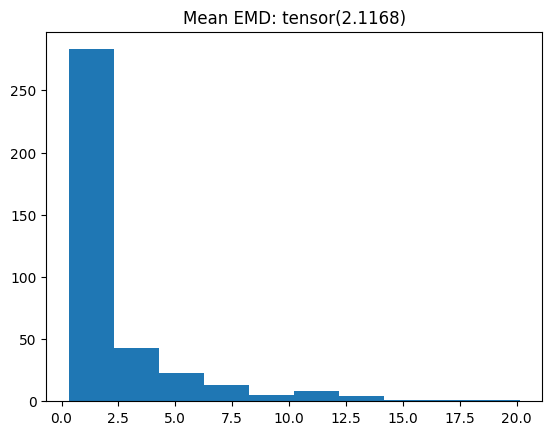

In [20]:
"""
# test
"""

plt.figure()
preds_, _, _ = test(0)
labels = torch.from_numpy(DATA["Y_test"]).to(device)
normed_preds, normed_labels = predictor.normalize(preds_, labels)
diff = normed_preds - normed_labels
cumsum_diff = torch.cumsum(diff, dim=1)
EMDs = torch.sum(torch.abs(cumsum_diff), dim=1)

plt.hist(EMDs.cpu())
plt.title("Mean EMD: "+str(torch.mean(EMDs.cpu())))

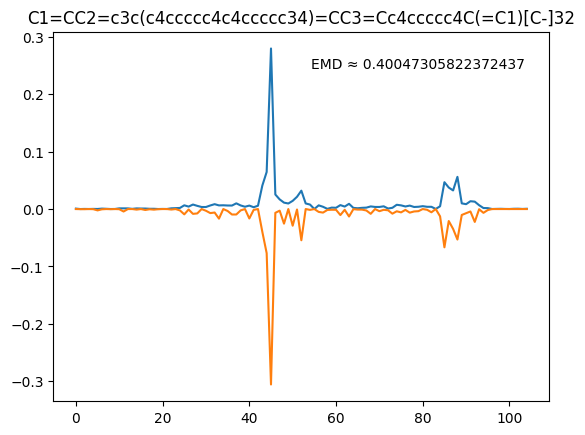

In [60]:
idx = 0
smi = DATA["smiles_test"][idx]
input =torch.tensor(DATA["X_test"][idx], dtype=torch.float).to(device)
label = torch.tensor(DATA["Y_test"][idx], dtype=torch.float).to(device)

Y_pred, EMD, _ = predictor(input, label)

normed_Y_pred, normed_label = predictor.normalize(Y_pred, label)
normed_Y_pred = normed_Y_pred.to("cpu").detach().numpy()
normed_label = normed_label.to("cpu").detach().numpy()

plt.title(smi)
plt.plot(normed_Y_pred[0])
plt.plot(-normed_label[0])
plt.text(0.95, 0.93, f'EMD ≈ {EMD.cpu()}', horizontalalignment='right', verticalalignment='top',
         transform=plt.gca().transAxes, fontsize=10)
plt.show()